# **THE STATISTICAL CUBE; A BRIEF MAGIC MODEL CREATON.**




### **INTRODUCTION**

This notebook is an attempt to generate models for rubik's puzzles world records prediction. Well, a try.

Together with this notebook ye'll find a .zip file containing the data necessary troughout the notebook. The data consists of seven .csv files; six of them having the solving world records (hope you notice all of them were taken in day 14, this is due to padronization in record cataloging), the seventh is "records.csv" and it hosts an overview of every cube's records time series.

Each code section has a text cell responsible for explaining why is that cell there.

---

### **Importation**

Just regular import cell, in the coments you can find the usage of each imported group

In [2]:
#Graphics construction
import seaborn as sns 
import matplotlib.pyplot as plt

#Data handleling and metrics
import pandas as pd  
import numpy as np 
from datetime import datetime 
from sklearn import preprocessing, metrics

#Data modeling 
import scipy.stats as stats
import statsmodels.api as sms 
import statsmodels.formula.api as smf 
from fbprophet import Prophet 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This cell imports the time series table. Since the table is an overview of all modalities - more on that later - it contains each cube's names; Hence it is also used to name each cube after it's commercial name

In [3]:
#Import the "base" table, it contains all cube's names and the data for time series creation
#The referentiation of each cube records data will be done after the class creation
series = pd.read_csv('data/records.csv',sep=';')
series['dates'] = pd.to_datetime(series['dates'])

### **Class and objects creation**

Remember the modalitiy thing? Well, there are six of them (there is more, but we'll focus on these six) each one with it's own cube with distinct dimesions.

There will be two models for each cube: linear and poisson; on behalf of a cleaner code and lesser number of cells, I opted for creating a class - which would execute those 12 models - and creating solely six objects which methods and atributes will be called as long as they're needed.

Each method is explained in the comments.

In [4]:
class Cube:
    #Creation of object's roots atributes such as name of the cube, records base and records time series 
    #Although other methods may create new atributes, they are a product of those first atributes
    def __init__(self, df1, df2):
        self.name = df1.columns[2]
        self.r_month = df1
        self.s_time = df2.iloc[:,[0, (df2.keys().tolist()).index(self.name)]].dropna()

        #Solely for technical purposes it's interesting to know if the data we work with is worth of working
        self.correlations, self.p_value = stats.pearsonr((self.r_month).months, self.r_month[f'{self.name}'])
        print(f"Pearson's {(self.name).title()} ~ Month correlation = {self.correlations}\n")

        #If p-value is under 0.05 it may be worthless the model creation
        if self.p_value > 0.05:
            print(f"P-value = {self.p_value}!")

        #Atributes which the purpose is to do not repeat processes already done
        #In each method executed these atributes get a "True" value
        #Before each method to be executed there is a checking if some of these atributes gos a "True" or not
        self.normalized = self.modeled = self.predicted = self.fb_modeled = self.fb_predicted = False
    
    #Method for ploting time series and scatter graphics for an exploratory analysis
    def graphics(self):
        plt.figure(figsize=(15,5))
        plt.suptitle(f'{self.name.title()}')
        for i in range(1,3):
            if i == 1:
                plt.subplot(1,2,i).set_title('Time Series')
                plt.plot('dates', f'{self.name}', data=self.s_time)
                plt.xlabel('years')
                plt.ylabel(f'{self.name}')
            elif i==2:
                plt.subplot(1,2,i).set_title('Scatter')
                sns.scatterplot(x=self.r_month['months'], y=self.r_month.iloc[:, i])
            plt.axhline(0, color='black')
        plt.tight_layout()

    #Method for normalizing data, which are the record times got on competitions
    def normalize(self):
        #Checking for normalizations already done
        if self.normalized:
            print('Já normalizado. -- Already normalized.')
            return

        #Function to normalize the data
        def norm (dataframe):
            self.normalizator = preprocessing.MinMaxScaler()
            i = 0
            if len(dataframe.columns) == 3:
                i = 1
            table = pd.DataFrame(columns=[dataframe.columns[i], f'{self.name}', f'mm_{self.name}'])
            table[[dataframe.columns[i], f'{self.name}']] = dataframe.iloc[:, [i, (dataframe.keys().tolist()).index(self.name)]]
            table[f'mm_{self.name}'] = self.normalizator.fit_transform(
                (dataframe.iloc[:,(dataframe.keys().tolist()).index(self.name)].values).reshape(-1,1)
                )
            return table

        #Normalized data creation
        self.n_month = norm(self.r_month)
        self.n_time = norm(self.s_time)
        self.normalized = True
        print('Normalização concluída! -- Sucessfull normalization!')

    #This method will create two models for each modeling
    #One with non-normalized data, other with normalized data
    def modeling (self, fb_model = False):
        if not self.modeled:

            #For not rewriting the same code, is created an array with the both models
            #Therefore it can't handle the algorithm without the normalized data
            if not self.normalized:
                print('Normalizando dados... -- Normalizing data...')
                self.normalize()

            #You can access all the info about each model refering to the array's 0 or 1 index for non-normalized and normalized models
            self.linear = [smf.ols('{} ~ months'.format((self.r_month).columns[2]), data=(self.r_month)).fit(),
                          smf.ols('{} ~ months'.format((self.n_month).columns[2]), data=(self.n_month)).fit()]

            self.poisson = [smf.poisson('{} ~ months'.format((self.r_month).columns[2]), data=(self.r_month)).fit(),
                            smf.poisson('{} ~ months'.format((self.n_month).columns[2]), data=(self.n_month)).fit()]

       
        #The Facebook Prophet model is a particular case; for the modeling method to run faster it isn't executed for default
        #To execute the algorithm you may call the method with "fb_model=True" argument
        if not self.fb_modeled:
            if fb_model:
                print('Modelando Facebook Prophet... -- Modeling Facebook Prophet...')
                time_s = (self.s_time).rename(columns = {'dates':'ds', self.name:'y'})
                self.fb_time_model = Prophet(yearly_seasonality=0, weekly_seasonality=0, daily_seasonality=0).fit(time_s)
                self.fb_modeled = True

        print('Modelagem concluida! -- Sucessfull modeling!')
        self.modeled = True

    #This method creates three new dataframes (one with non normalized, one with normalized and one with unormalized models predictions) this helps in the "reg_graphics()" method
    def modeling_previsions (self, n_prev=None):
        if not self.modeled:
            print('Modelando para prever... -- Modeling data for previsions...')
            self.modeling()

        if not self.predicted:
            #Non normalized
            monthly_model = pd.DataFrame(columns=['months', f'{self.name}', 'lin','poi'])
            monthly_model[['months', f'{self.name}']] = self.r_month.iloc[:,[1,2]]
            monthly_model.iloc[:, 2:4] = np.column_stack([self.linear[0].predict((self.r_month).months),
                                                          self.poisson[0].predict((self.r_month).months)])

            #Model with values in range 0, 1
            #The "mm_" prefix stands for "MinMax"        
            minmax = pd.DataFrame(columns=['months', f'mm_{self.name}','mm_lin','mm_poi'])
            minmax[['months', f'mm_{self.name}']] = self.n_month.iloc[:,[0,2]]
            minmax.iloc[:, 2:4] =  np.column_stack([self.linear[1].predict((self.n_month).months),
                                                    self.poisson[1].predict((self.n_month).months)])
            
            #Normalized
            #The "n_" stands for "normalized"
            normalized_model = pd.DataFrame(columns=['months', f'n_{self.name}','n_lin','n_poi'])
            normalized_model[['months', f'n_{self.name}']] = self.r_month.iloc[:,[1,2]]
            normalized_model.iloc[:, 2:4] = self.normalizator.inverse_transform((minmax).iloc[:, 2:4])

            self.models = [monthly_model, normalized_model, minmax] 
        
        #Again, to run a Facbook Prophet based algorithm you may pass the argument on calling the method
        #In this method the argument is "n_prev" which is an integer that represents the number of steps to be predicted for Facebook Prophet model
        if not (n_prev == None):
            if not self.fb_modeled:
                print('Modelando com Facebook Prophet... -- Modelando with Facebook Prophet...')
                self.modeling(fb_model=True)

            if not self.fb_predicted:
                print('Prevendo com Facebook Prophet... -- Predicting with Facebook Prophet...')
                self.fb_prophet_predictions = (self.fb_time_model).predict((self.fb_time_model).make_future_dataframe(periods=n_prev, freq='MS'))
                self.fb_predicted = True
            else:
                print('Facebook Prophet já previsto. -- Facebook Prophet has already been predicted.')

        print('Previsões concluidas! -- Sucessfully predicted!')
        self.predicted = True
    
    #This method generate two Facebook Prophet graphics; with non and normalized data
    def fb_graphics(self):
        if not (self.fb_modeled & self.fb_predicted):
            print('Facebook Prophet deve ser modelado (.modeling(fb_modeled=True)) e previsto (.modeling_previsions(n_prev=(int > 0)))')
            print('')
            print('Facebook Prophet may be modeled (.modeling(fb_modeled=True)) and predicted (.modeling_previsions(n_prev=(int > 0)))')
            return

        (self.fb_time_model).plot((self.fb_prophet_predictions), xlabel='Date', ylabel='Time')

    #Metrics for model evaluation
    def metrics_results(self, model=None, normalized=False):
        models = {'poisson':3, 'linear':2}
        table = self.models[normalized]
        series = [table.iloc[:, 1], table.iloc[:, models[model]]]
        print(f'{model.upper()}')
        print(f'\tR² = {metrics.r2_score(series[0], series[1])}')
        print(f'\tMAE = {metrics.mean_absolute_error(series[0], series[1])}')
        print(f'\tMAPE = {metrics.mean_absolute_percentage_error(series[0], series[1])}')        
        print(f'\tRMSE = {metrics.mean_squared_error(series[0], series[1], squared=False)}')
        print(f'\tAIC = {getattr(self, model)[normalized].aic}')
        print(f'\tBIC = {getattr(self, model)[normalized].bic}')

    #Method for predicting
    def pred_future (self, model=None, normalized=False, predict=[1,3,6,12,24,36,48,60,72,84,96,108,120]):
        months = np.array(predict).reshape(-1,1)
        
        #In order for making previsions we need a dataframe to hold the independent variable values to predict
        number_of_months = pd.DataFrame(months + max(self.r_month['months']), columns=['months'])
        predicted = (getattr(self, model)[normalized]).predict(number_of_months).values.reshape(-1,1)

        #If using the normalized model, it may pass trought an inverse transform in order to get the actual values
        if normalized:
            predicted = self.normalizator.inverse_transform(predicted)
            return predicted
        else:
            return predicted

    #This method also generate two graphics, but seaborn graphics for both non and normalized data models
    def reg_graphics(self, normalized=True):
        if not self.predicted:
            print('Prevendo dados... -- Predicting')
            self.modeling_previsions()

        plt.figure(figsize=(15,5))
        plt.suptitle(f'{self.name.title()}')
        for i in range(1,3):
            if i == 1:
                dataframe = self.models[0]
                plt.subplot(1,2,i).set_title('Non normalized model')
            elif i==2:
                if normalized:
                    dataframe = self.models[1]
                    plt.subplot(1,2,i).set_title('Normalized Model')
                else:
                    dataframe = self.models[2]
                    plt.subplot(1,2,i).set_title('0-1 Previsions')

            sns.scatterplot(x=dataframe['months'], y=dataframe.iloc[:, 1])
            sns.lineplot(x=dataframe['months'], y=dataframe.iloc[:,(2)], color='green')
            sns.lineplot(x=dataframe['months'], y=dataframe.iloc[:,(3)], color='purple')
            plt.legend(labels=['Linear', 'Poisson'])
            plt.axhline(0, color='black')
        plt.tight_layout()

This cell contains a repetition function which wil allow to create those six classes with just one cell. This function is executed right below.

In [5]:
#This function returns an array with each cube object created
#The cube objects may be atributed to a variable; if not in the calling of function, they'll be avaliable in the list created by the function
def create_cubes ():
    cubes = []
    for i in range(1, len(series.columns.tolist())):
        dataframe = pd.read_csv(f'data/{(series.columns.tolist()[i])}.csv', sep=';')
        dataframe['dates'] = pd.to_datetime(dataframe['dates'])    
        cubes.append(Cube(dataframe, series))
    return cubes

### **The models creation**

The first thing in an analysis is know what we are analysing, how to refer to it and it's Correlation. The following code create the objects which'll be our subjects in this analysis and, also, showed the respective correlations between the months passed and the records registered.

See that none of then warned about the p-vallues; That means all of them have a significant correlation.

In [6]:
two, three, four, five, six, seven = create_cubes()

Pearson's Pocket ~ Month correlation = -0.7895978179826855

Pearson's Rubik ~ Month correlation = -0.9245563249924857

Pearson's Revenge ~ Month correlation = -0.9165927461712134

Pearson's Professor ~ Month correlation = -0.9269108322122265

Pearson's V6 ~ Month correlation = -0.953303560007494

Pearson's V7 ~ Month correlation = -0.9800500226575172



The code above created six variables, each one's names refer to the "size" of the cube, because, even in the World Cube Association's site, is usual to refer to the cubes by it's volume (edge * edge * edge). Abreviating, edge. The edge is a counting of how many pieces there are in the edge. It shall be clearer soon.

#### Just explanation

When you buy bolts or nails you may specify it's dimensions, since distinct dimensions are meant for different purposes - like pinning two thin or thick pieces of wood. Thus the nails and bolts are measured by it's size, and so are the rubik's cubes puzzles: they have different dimensions, hence different modakities of competition for different sizes.

But what is the measuring unit for rubik's cubes? It is how many pieces are fit in it's edge! Then if we have a cbe with only two pieces in its edge we can call it a two by two by two (edge * edge * edge), alternatively if have a cube with seven pieces in the edge we also can have a seven by seven (edge * edge).

The WCA rules six modalities: two by two by two cubes, three by three by three, four by four by four, five by five, six by six and seven by seven. Those cubes are selled under the names pocket cube, rubik's cube, rubik's revenge, professor's cube, v-6 cube and v-7 cube.

#### Pocket cube

Firstly we shall see what are the records of this cube by calling it's records by months dataframe atribute.

"r_month" stands for "records by month"

In [20]:
two.r_month

,dates,months,pocket
0,2004-10-14,0,8.44
1,2005-04-14,6,6.35
2,2005-05-14,7,4.92
3,2005-06-14,8,4.13
4,2005-12-14,14,3.94
5,2006-06-14,20,3.55
6,2007-07-14,33,2.73
7,2007-11-14,37,2.65
8,2008-03-14,41,1.63
9,2008-11-14,49,0.96


As nentioned before, all the datas take place in day 14. So the first record was in 2004 by the october month with 8.44 seconds. Drastic change until 13th record in april 2006 with 0.49 second. 

Next we'll see the time series and the record by months scatter graphic.

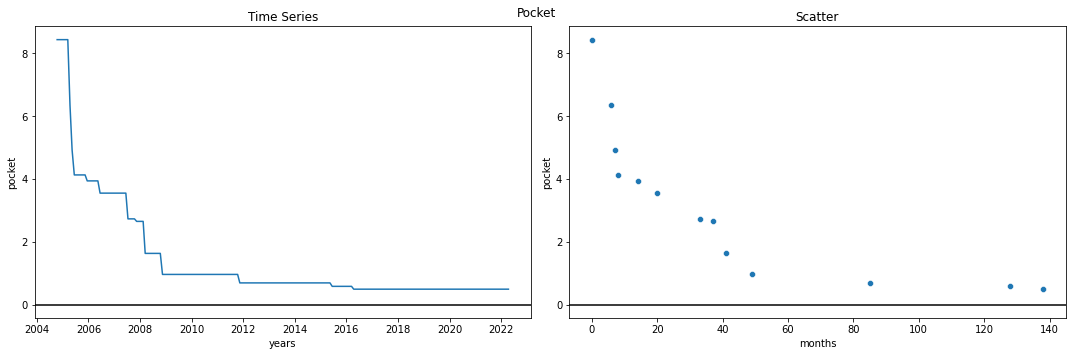

In [21]:
two.graphics()

Notice in the scatter graphic that the newet records are considerably more spaced than the others. The pocket cube have the fewest number of records of all cubes.

In the time series graphic we see how old are the current record

I particularly like the following cell, it will normalized the records obtained.

It's part of the characteristics dimensioning and it may (or may not) help our model, it is called "Min Max normalization" and all the data will be transformed to a number greater than 0 and lesser than 1 (the only exception is for outliers, but there are no outliers in a series that is essencialy an outliers series).

Following up we'll see a table to compare the normalized data.

"n_month" stands for "normalized records by month"

In [54]:
two.normalize()
two.n_month

Normalização concluída! -- Sucessfull normalization!


,months,pocket,mm_pocket
0,0,8.44,1.000000
1,6,6.35,0.737107
2,7,4.92,0.557233
3,8,4.13,0.457862
4,14,3.94,0.433962
5,20,3.55,0.384906
6,33,2.73,0.281761
7,37,2.65,0.271698
8,41,1.63,0.143396
9,49,0.96,0.059119


This next step is where the things get exciting, it will be the creation of the models for future previsions. 

And after the model creation will be executed the prevision method, which will pass our months column trough the models so that we can see how the model actualy interact with the already existing data (if it miss or predic correctly).

There will be generated two models: a linear model and a poisson model.

In [55]:
two.modeling()
two.modeling_previsions()

Optimization terminated successfully.
         Current function value: 1.468826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500230
         Iterations 7
Modelagem concluida! -- Sucessfull modeling!
Previsões concluidas! -- Sucessfully predicted!


We can now access the new tables with each models predictions.

The tables can be accessed by the atribute "models", which is an array with:

>Table with models created using raw data in position 0;

>Table with normalized models data in position 1. Each columns has the prefix "n_" which refers to the normalized model;

>Table with 0-1 range models. It's columns prefix is "mm_".

In [41]:
two.models[0]

,months,pocket,lin,poi
0,0,8.44,4.971637,6.355150
1,6,6.35,4.721765,5.456296
2,7,4.92,4.680119,5.319366
3,8,4.13,4.638474,5.185873
4,14,3.94,4.388602,4.452398
5,20,3.55,4.138729,3.822664
6,33,2.73,3.597340,2.747086
7,37,2.65,3.430758,2.481534
8,41,1.63,3.264177,2.241653
9,49,0.96,2.931014,1.829214


In [32]:
two.models[1]

,months,n_pocket,n_lin,n_poi
0,0,8.44,4.971637,7.293285
1,6,6.35,4.721765,5.812003
2,7,4.92,4.680119,5.598592
3,8,4.13,4.638474,5.393738
4,14,3.94,4.388602,4.326045
5,20,3.55,4.138729,3.490822
6,33,2.73,3.597340,2.252703
7,37,2.65,3.430758,1.986523
8,41,1.63,3.264177,1.760538
9,49,0.96,2.931014,1.405791


In [33]:
two.models[2]

,months,mm_pocket,mm_lin,mm_poi
0,0,1.000000,0.563728,0.855759
1,6,0.737107,0.532297,0.669434
2,7,0.557233,0.527059,0.642590
3,8,0.457862,0.521821,0.616822
4,14,0.433962,0.490390,0.482521
5,20,0.384906,0.458960,0.377462
6,33,0.281761,0.390860,0.221724
7,37,0.271698,0.369907,0.188242
8,41,0.143396,0.348953,0.159816
9,49,0.059119,0.307046,0.115194


It will be better seen in the next cell which is the most pleasing part of this analysis, will be ploted the graphics with the models prediction's and the actual data.

By default the method creates the non and normalized models graphics. If, by curiosity or any sort of feeling, you want to see the 0-1 range graphic you can use

    two.reg_graphics(normalized = False)

"two" being the cube we've created and "reg_graphics" standing for "regression graphics".

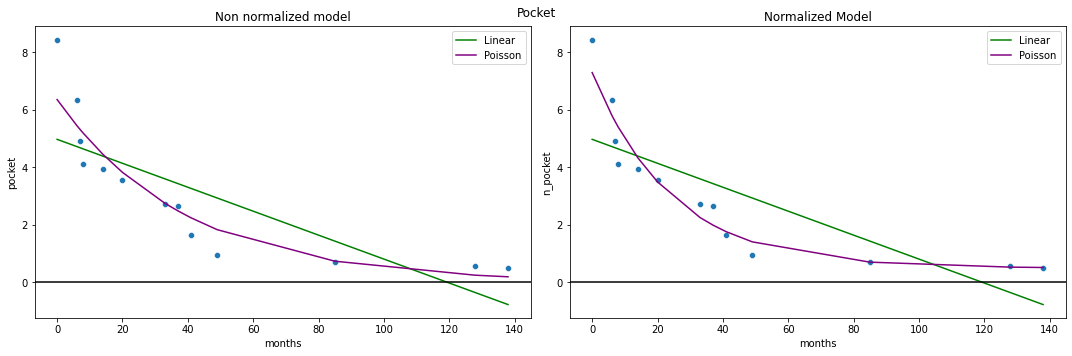

In [90]:
two.reg_graphics()

In this case looks like normalizing the data helped in the model creation.

We can confirm by seeing some metrics.

In [35]:
two.metrics_results(model='poisson', normalized=True)

POISSON
	R² = 0.933180249661222
	MAE = 0.4520847988865587
	MAPE = 0.1465353485945023
	RMSE = 0.6013964370495107
	AIC = 17.005985784759012
	BIC = 18.135884499682085


This shows that in the normalized case the poisson model works for predictions.

So if we are looking for making predictions we can use the method 
    
    .pred_future(model = None, normalized = False, predict = [1, 3, 6, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120])

>Model = name of the model wanted;

>Normalized = if wanted to use the non or normalized model. Default = Non normalized;

>Predict = array or int of how many months we wnat to predict. Default 1, 3 and 6 months ahead, then each of ten years ahead.

"pred_future" stands for "predict future".

Predicting the record in 36 months.

In [61]:
two.pred_future(model='poisson', normalized=True, predict=36)

array([[0.49549612]])

Predicting the default period of months

In [62]:
two.pred_future('poisson', True)

array([[0.51302201],
       [0.51121267],
       [0.50876176],
       [0.50467675],
       [0.49898138],
       [0.49549612],
       [0.49336332],
       [0.49205817],
       [0.49125949],
       [0.49077074],
       [0.49047165],
       [0.49028862],
       [0.49017662]])

We can explore the characteristics of any model by printing the model summary.

Remember we made two models, one non and other normalized? Well, we shall refer to each specific model to get the summary. Both are stored in an array the we can call by the atribute of the model type (binomial and poisson in this case).

The non normalized model is in array's 0 position; the normalized, in 1 position.

In [217]:
print(two.poisson[1].summary())

                          Poisson Regression Results                          
Dep. Variable:               n_pocket   No. Observations:                   13
Model:                        Poisson   Df Residuals:                       11
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.2103
Time:                        13:35:56   Log-Likelihood:                -6.5030
converged:                       True   LL-Null:                       -8.2346
Covariance Type:            nonrobust   LLR p-value:                   0.06275
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1558      0.642     -0.243      0.808      -1.413       1.102
months        -0.0409      0.032     -1.262      0.207      -0.104       0.023


#### Rubik's cube

The same way done to Pocket's analysis shall be done for other cubes analysis.

The object is already created with the edge's number of pieces as it's name.

In [218]:
three.r_month

,dates,months,rubik
0,2003-09-14,0,16.53
1,2004-02-14,5,14.76
2,2004-04-14,7,12.11
3,2005-11-14,26,11.75
4,2006-01-14,28,11.13
5,2006-08-14,35,10.48
6,2007-03-14,42,10.36
7,2007-05-14,44,9.86
8,2007-10-14,49,9.77
9,2007-12-14,51,9.55


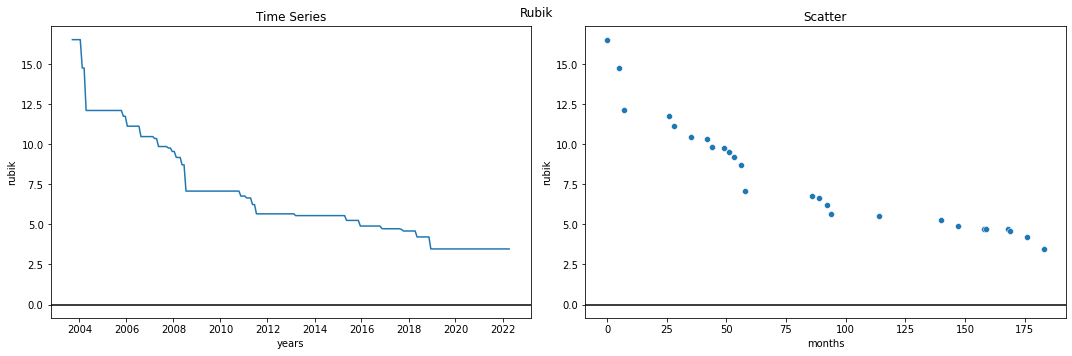

In [219]:
three.graphics();

If you want to save some time, you can call directly for the regression graphics.

Prevendo dados... -- Predicting
Modelando para prever... -- Modeling data for previsions...
Normalizando dados... -- Normalizing data...
Normalização concluída! -- Sucessfull normalization!
Optimization terminated successfully.
         Current function value: 1.968787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541958
         Iterations 6
Modelagem concluida! -- Sucessfull modeling!
Previsões concluidas! -- Sucessfully predicted!


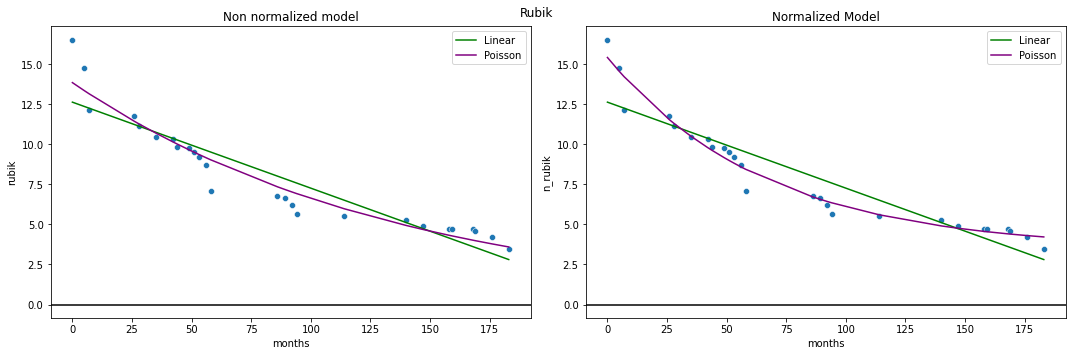

In [63]:
three.reg_graphics()

If we see the metrics we may think the best model is the normalized one.

Take the poisson model for instance.

In [64]:
print('Raw Data')
three.metrics_results('poisson')
print('Normalized model')
three.metrics_results('poisson', True)

Raw Data
POISSON
	R² = 0.9354646470900173
	MAE = 0.6050218274952724
	MAPE = 0.08059178344746297
	RMSE = 0.8578163087806969
	AIC = 106.37691571617604
	BIC = 108.89310879221901
Normalized model
POISSON
	R² = 0.9654225216278027
	MAE = 0.4175465003926798
	MAPE = 0.05475176227557729
	RMSE = 0.6279023569792563
	AIC = 32.181795704133044
	BIC = 34.69798878017601


But in my assesment the newest records are even more relevant than the older ones. 

It will be clearer soon, when we make soome previsions. 

The two following dataframes show a comparison of the non and unormalized model.

In [65]:
three.models[0]

,months,rubik,lin,poi
0,0,16.53,12.629203,13.848766
1,5,14.76,12.360878,13.347740
2,7,12.11,12.253548,13.152442
3,26,11.75,11.233913,11.433880
4,28,11.13,11.126583,11.266585
5,35,10.48,10.750928,10.700094
6,42,10.36,10.375273,10.162087
7,44,9.86,10.267943,10.013400
8,49,9.77,9.999618,9.651131
9,51,9.55,9.892288,9.509920


In [66]:
three.models[1]

,months,n_rubik,n_lin,n_poi
0,0,16.53,12.629203,15.416886
1,5,14.76,12.360878,14.546589
2,7,12.11,12.253548,14.216489
3,26,11.75,11.233913,11.531978
4,28,11.13,11.126583,11.291718
5,35,10.48,10.750928,10.505808
6,42,10.36,10.375273,9.798865
7,44,9.86,10.267943,9.610255
8,49,9.77,9.999618,9.162954
9,51,9.55,9.892288,8.993295


Notice the monthly_model aproach the last records from up with an error of 0.12 second. And see how far up the unormalized model goes.

See the non normalized model previsions.

In [67]:
three.pred_future('poisson')

array([[3.5685162 ],
       [3.51630332],
       [3.43941293],
       [3.29063941],
       [3.01211984],
       [2.75717415],
       [2.52380705],
       [2.31019213],
       [2.11465757],
       [1.93567305],
       [1.77183777],
       [1.6218695 ],
       [1.48459453]])

Notice that has been a few months for the model to catch up the actual record.

Now the normalized model.

In [68]:
three.pred_future('poisson', True)

array([[4.20862404],
       [4.18661182],
       [4.15481736],
       [4.0953978 ],
       [3.99157831],
       [3.90499343],
       [3.83278212],
       [3.77255829],
       [3.72233194],
       [3.68044345],
       [3.64550867],
       [3.61637327],
       [3.5920745 ]])

See that in ten years predicted the model couldn't catch up the actual record of 3.47 seconds.

Mostly because of that I say the poisson non normalized model is better for this case.

And we can see the model summary.

In [226]:
print(three.poisson[0].summary())

                          Poisson Regression Results                          
Dep. Variable:                  rubik   No. Observations:                   26
Model:                        Poisson   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.2462
Time:                        13:35:57   Log-Likelihood:                -51.188
converged:                       True   LL-Null:                       -67.909
Covariance Type:            nonrobust   LLR p-value:                 7.342e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6282      0.109     24.075      0.000       2.414       2.842
months        -0.0074      0.001     -5.509      0.000      -0.010      -0.005


#### Rubik's Revenge

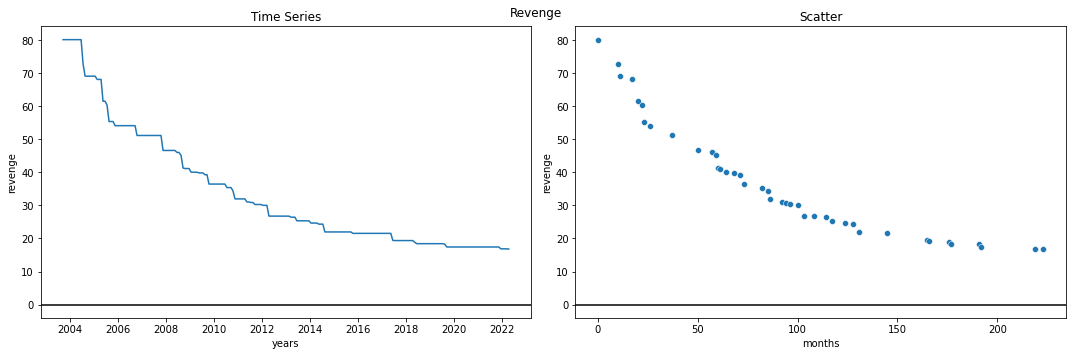

In [227]:
four.graphics()

And for saving even more time...

Prevendo dados... -- Predicting
Modelando para prever... -- Modeling data for previsions...
Normalizando dados... -- Normalizing data...
Normalização concluída! -- Sucessfull normalization!
Optimization terminated successfully.
         Current function value: 2.818259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496855
         Iterations 6
Modelagem concluida! -- Sucessfull modeling!
Previsões concluidas! -- Sucessfully predicted!


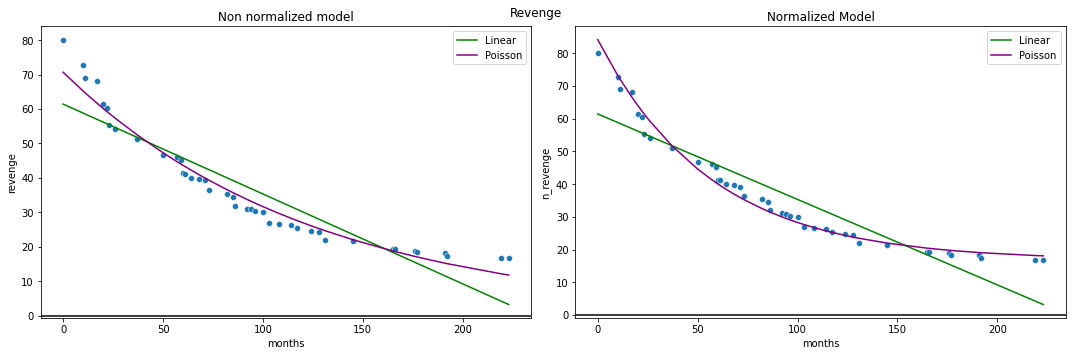

In [69]:
four.reg_graphics()

The poisson normalized model looks like being the best again perharps.

In [70]:
four.models[1]

,months,n_revenge,n_lin,n_poi
0,0,80.16,61.445130,84.146550
1,10,72.85,58.834201,73.236890
2,11,69.11,58.573108,72.248234
3,17,68.12,57.006550,66.669506
4,20,61.52,56.223271,64.094254
5,22,60.38,55.701085,62.451717
6,23,55.38,55.439992,61.651961
7,26,54.13,54.656713,59.335762
8,37,51.16,51.784690,51.820191
9,50,46.63,48.390481,44.630738


In [230]:
four.metrics_results('poisson', True)

POISSON
	R² = 0.9815755676063913
	MAE = 1.7865277789940435
	MAPE = 0.04880554086140924
	RMSE = 2.293681333660885
	AIC = 44.74214492577847
	BIC = 48.169289059187086


In [71]:
four.pred_future('poisson', True)

array([[18.07649445],
       [18.03182373],
       [17.96770904],
       [17.84923938],
       [17.64685303],
       [17.48313616],
       [17.35070028],
       [17.24356861],
       [17.15690634],
       [17.08680242],
       [17.03009308],
       [16.98421907],
       [16.94711009]])

Well, didn't really catch up the current record, but, if we subtract the mean absolute error or the root mean squared error, maybe we can have a viable model since the newest records are always two seconds below the predicted record.

In [73]:
four.pred_future('poisson', True) - metrics.mean_absolute_error(four.models[1].n_revenge, four.models[1].n_poi)

array([[16.28996668],
       [16.24529595],
       [16.18118126],
       [16.0627116 ],
       [15.86032525],
       [15.69660838],
       [15.5641725 ],
       [15.45704083],
       [15.37037856],
       [15.30027464],
       [15.24356531],
       [15.19769129],
       [15.16058231]])

Or even multiply by the mean absolute percentage error complement

In [74]:
four.pred_future('poisson', True) * (1 - metrics.mean_absolute_percentage_error(four.models[1].n_revenge, four.models[1].n_poi))

array([[17.19426137],
       [17.15177082],
       [17.09078528],
       [16.9780976 ],
       [16.78558883],
       [16.62986224],
       [16.50388997],
       [16.40198692],
       [16.31955424],
       [16.25287178],
       [16.19893018],
       [16.15529507],
       [16.11999722]])

In [234]:
print(four.poisson[1].summary())

                          Poisson Regression Results                          
Dep. Variable:              n_revenge   No. Observations:                   41
Model:                        Poisson   Df Residuals:                       39
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.1847
Time:                        13:35:59   Log-Likelihood:                -20.371
converged:                       True   LL-Null:                       -24.986
Covariance Type:            nonrobust   LLR p-value:                  0.002382
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0610      0.426      0.143      0.886      -0.773       0.895
months        -0.0177      0.007     -2.633      0.008      -0.031      -0.005


#### Professor's cube

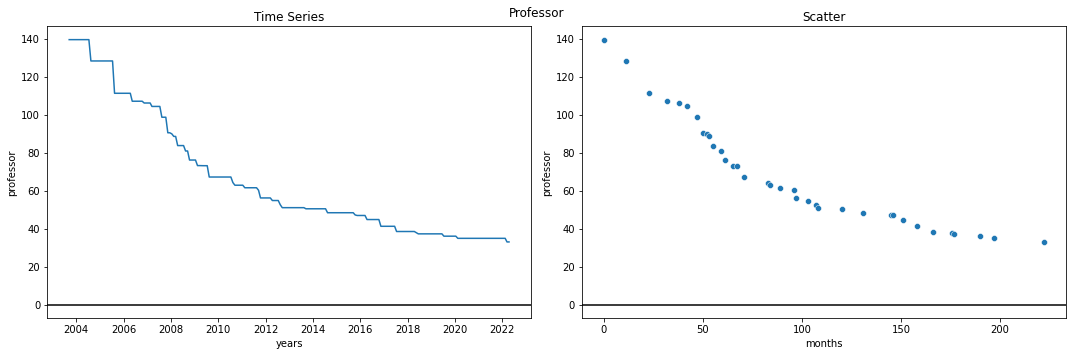

In [235]:
five.graphics()

Prevendo dados... -- Predicting
Modelando para prever... -- Modeling data for previsions...
Normalizando dados... -- Normalizing data...
Normalização concluída! -- Sucessfull normalization!
Optimization terminated successfully.
         Current function value: 3.222340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523295
         Iterations 6
Modelagem concluida! -- Sucessfull modeling!
Previsões concluidas! -- Sucessfully predicted!


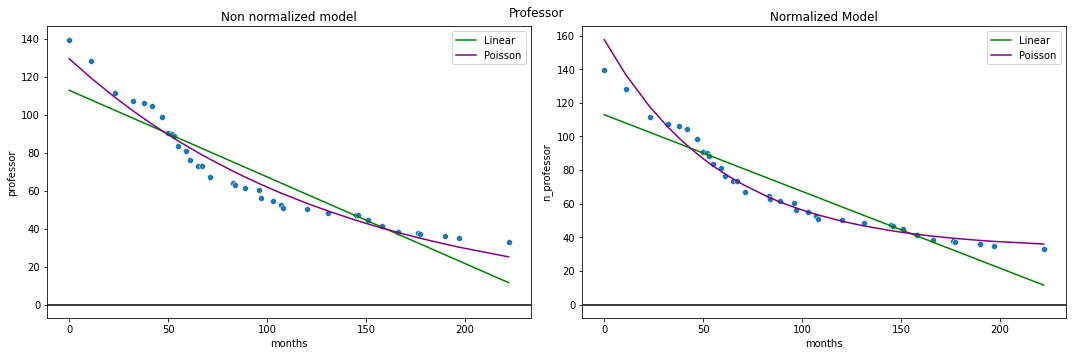

In [75]:
five.reg_graphics()

In [76]:
five.models[1]

,months,n_professor,n_lin,n_poi
0,0,139.69,112.985040,157.612985
1,11,128.45,107.959600,136.595985
2,23,111.41,102.477303,117.690185
3,32,107.22,98.365580,105.812072
4,38,106.28,95.624431,98.834229
5,42,104.47,93.796998,94.558033
6,47,98.78,91.512708,89.601359
7,50,90.58,90.142133,86.821109
8,52,90.03,89.228417,85.043928
9,53,88.66,88.771559,84.177474


In [77]:
five.pred_future('poisson', True)

array([[35.96388651],
       [35.86664277],
       [35.72676672],
       [35.46729625],
       [35.02058947],
       [34.6554204 ],
       [34.35690592],
       [34.1128795 ],
       [33.9133954 ],
       [33.75032328],
       [33.61701684],
       [33.50804292],
       [33.41896008]])

Did not catch up, we may see the metrics.

In [239]:
five.metrics_results('poisson', True)

POISSON
	R² = 0.9703112668062076
	MAE = 3.2559518915672974
	MAPE = 0.04387347522204318
	RMSE = 4.782492124509088
	AIC = 41.67721346067955
	BIC = 44.84425133759177


And multiplying by the MAPE complement...

In [79]:
five.pred_future('poisson', True) * (1 - metrics.mean_absolute_percentage_error(five.models[1].n_professor, five.models[1].n_poi))

array([[34.38602583],
       [34.2930485 ],
       [34.15930931],
       [33.91122271],
       [33.4841145 ],
       [33.13496668],
       [32.84954906],
       [32.61622892],
       [32.42549689],
       [32.26957931],
       [32.14212148],
       [32.03792862],
       [31.95275417]])

And so we have viabl predictions.

In [241]:
print(five.poisson[1].summary())

                          Poisson Regression Results                          
Dep. Variable:            n_professor   No. Observations:                   36
Model:                        Poisson   Df Residuals:                       34
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.1627
Time:                        13:36:00   Log-Likelihood:                -18.839
converged:                       True   LL-Null:                       -22.500
Covariance Type:            nonrobust   LLR p-value:                  0.006811
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1553      0.488      0.318      0.750      -0.802       1.112
months        -0.0168      0.007     -2.386      0.017      -0.031      -0.003


#### V-6 cube

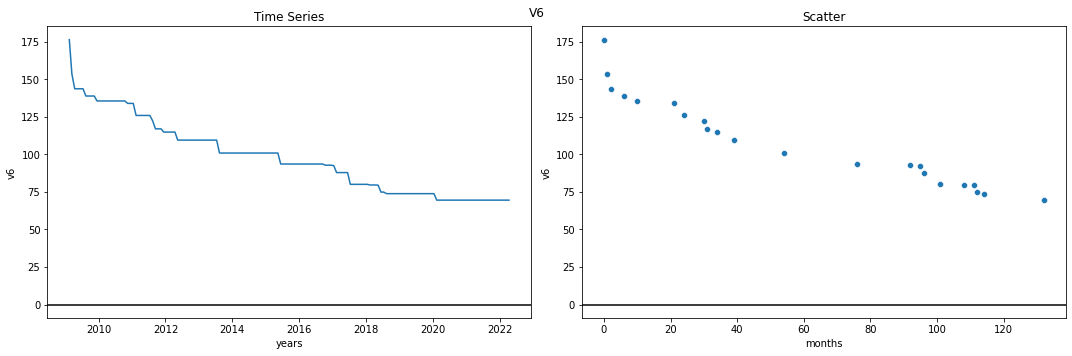

In [242]:
six.graphics()

Prevendo dados... -- Predicting
Modelando para prever... -- Modeling data for previsions...
Normalizando dados... -- Normalizing data...
Normalização concluída! -- Sucessfull normalization!
Optimization terminated successfully.
         Current function value: 3.454163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557455
         Iterations 6
Modelagem concluida! -- Sucessfull modeling!
Previsões concluidas! -- Sucessfully predicted!


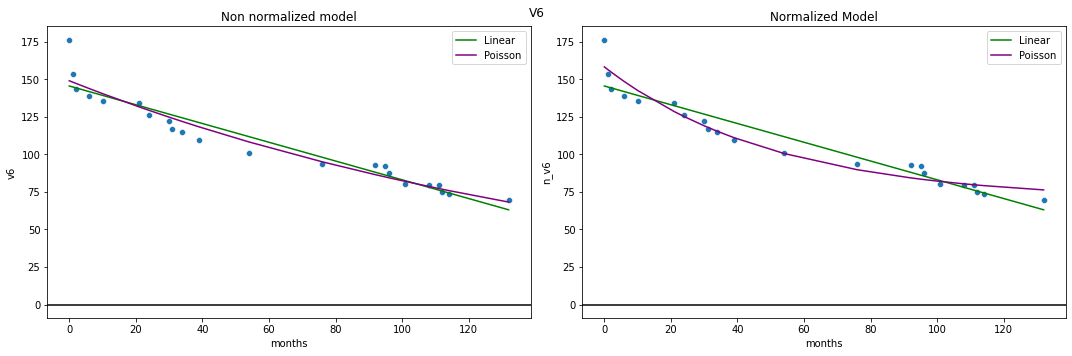

In [80]:
six.reg_graphics()

Again, seems like the normalized model don't catch the current record.

In [81]:
six.models[0]

,months,v6,lin,poi
0,0,176.34,145.482744,148.967697
1,1,153.55,144.858492,148.089079
2,2,143.63,144.234241,147.215642
3,6,138.81,141.737234,143.773109
4,10,135.53,139.240228,140.411077
5,21,133.90,132.373459,131.565361
6,24,125.88,130.500705,129.251128
7,30,122.31,126.755195,124.744068
8,31,116.96,126.130943,124.008321
9,34,114.81,124.258188,121.827016


In [246]:
six.metrics_results('poisson')

POISSON
	R² = 0.9331676177275451
	MAE = 5.173988260029393
	MAPE = 0.04398533378199137
	RMSE = 7.459724109473527
	AIC = 155.98317738218083
	BIC = 158.16526228889745


So we can use the non normalized model for making predictions.

In [82]:
six.pred_future('poisson', False)

array([[67.82742589],
       [67.02968657],
       [65.85063515],
       [63.55438602],
       [59.19931017],
       [55.14266668],
       [51.36400542],
       [47.84427761],
       [44.56573979],
       [41.51186437],
       [38.66725632],
       [36.01757555],
       [33.54946463]])

In [248]:
print(six.poisson[0].summary())

                          Poisson Regression Results                          
Dep. Variable:                     v6   No. Observations:                   22
Model:                        Poisson   Df Residuals:                       20
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.5059
Time:                        13:36:02   Log-Likelihood:                -75.992
converged:                       True   LL-Null:                       -153.81
Covariance Type:            nonrobust   LLR p-value:                 1.017e-35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0037      0.031    163.014      0.000       4.944       5.064
months        -0.0059      0.000    -12.255      0.000      -0.007      -0.005


#### V-7 cube

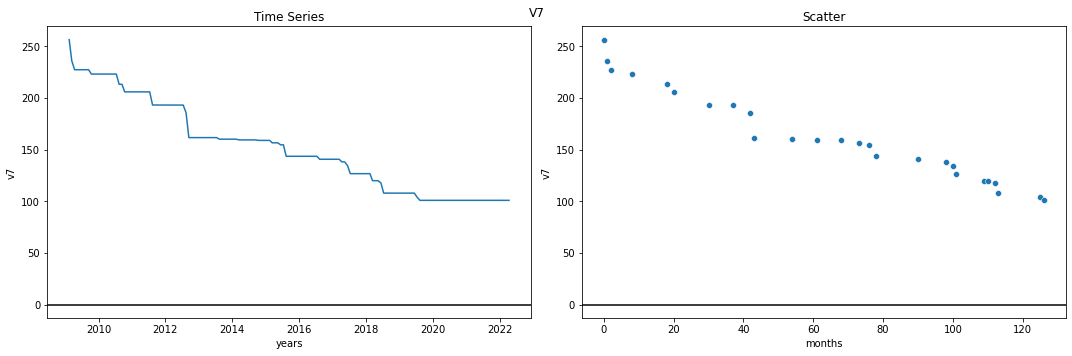

In [249]:
seven.graphics()

Prevendo dados... -- Predicting
Modelando para prever... -- Modeling data for previsions...
Normalizando dados... -- Normalizing data...
Normalização concluída! -- Sucessfull normalization!
Optimization terminated successfully.
         Current function value: 3.608850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591428
         Iterations 6
Modelagem concluida! -- Sucessfull modeling!
Previsões concluidas! -- Sucessfully predicted!


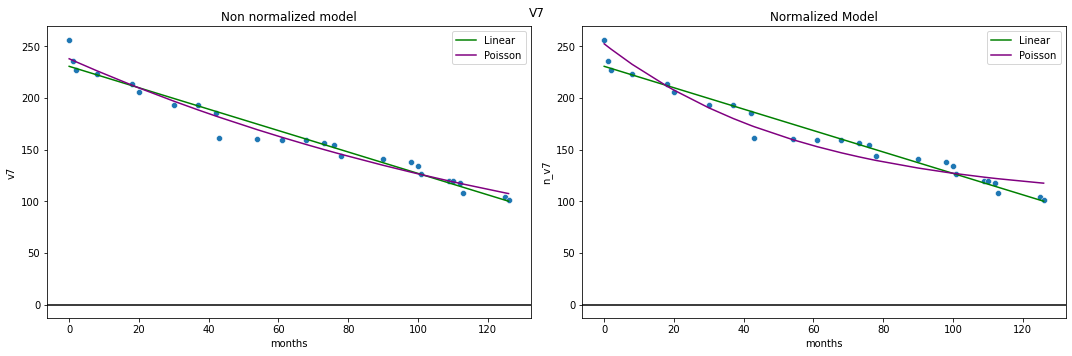

In [83]:
seven.reg_graphics()

That's actualy interesting, the linear model fit better in both cases, I'd not expect that. Well, since they're records it isn't surprising they get lower with passing time. 

However, is not posible, in regards to the competition rules logic, to have records of 0.00 second or -1.45 second: One case would be an already solved cube and the other would be a time traveling solve.

Then once the linear function intercept x axis it wouldn't be a viable model at first glance, would be imagined that a non linear model get a better fit.

In [84]:
seven.models[0]

,months,v7,lin,poi
0,0,256.47,230.622677,237.962589
1,1,236.06,229.586353,236.465638
2,2,227.36,228.550028,234.978105
3,8,223.15,222.332083,226.247365
4,18,213.25,211.968840,212.411040
5,20,205.91,209.896192,209.747018
6,30,193.19,199.532949,196.919784
7,37,193.11,192.278680,188.410386
8,42,185.80,187.097058,182.558315
9,43,161.63,186.060734,181.409896


In [85]:
seven.metrics_results('linear')
seven.metrics_results('poisson')

LINEAR
	R² = 0.9604980469109998
	MAE = 5.606544500726454
	MAPE = 0.0343047043287094
	RMSE = 8.578957045133844
	AIC = 189.54904590584675
	BIC = 192.0652389818897
POISSON
	R² = 0.9710557572917333
	MAE = 5.4948763584656986
	MAPE = 0.034881665846287775
	RMSE = 7.3435541983938775
	AIC = 191.66019862605572
	BIC = 194.17639170209867


Closest results; slightly lesser errors in the poisson model, but higher information criteria in the linear model.



In [253]:
print(seven.linear[0].summary())

                            OLS Regression Results                            
Dep. Variable:                     v7   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     583.6
Date:                Tue, 28 Jun 2022   Prob (F-statistic):           2.37e-18
Time:                        13:36:04   Log-Likelihood:                -92.775
No. Observations:                  26   AIC:                             189.5
Df Residuals:                      24   BIC:                             192.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    230.6227      3.300     69.891      0.0

In [254]:
print(seven.poisson[0].summary())

                          Poisson Regression Results                          
Dep. Variable:                     v7   No. Observations:                   26
Model:                        Poisson   Df Residuals:                       24
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.6015
Time:                        13:36:04   Log-Likelihood:                -93.830
converged:                       True   LL-Null:                       -235.48
Covariance Type:            nonrobust   LLR p-value:                 1.441e-63
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4721      0.026    213.283      0.000       5.422       5.522
months        -0.0063      0.000    -16.766      0.000      -0.007      -0.006


Think both models are viable options for predicting new records in this case.

In [86]:
seven.pred_future('linear')

array([[ 99.0094975 ],
       [ 96.936849  ],
       [ 93.82787626],
       [ 87.60993078],
       [ 75.17403982],
       [ 62.73814885],
       [ 50.30225789],
       [ 37.86636692],
       [ 25.43047596],
       [ 12.99458499],
       [  0.55869403],
       [-11.87719694],
       [-24.3130879 ]])

In [87]:
seven.pred_future('poisson')

array([[106.76940889],
       [105.430326  ],
       [103.4531255 ],
       [ 99.60926814],
       [ 92.34470869],
       [ 85.60995761],
       [ 79.36637569],
       [ 73.57814167],
       [ 68.21204679],
       [ 63.23730419],
       [ 58.62537235],
       [ 54.34979127],
       [ 50.3860307 ]])

Looks like the really good model is the non linear, but with a slightly adjust.

In [88]:
seven.pred_future('poisson') - metrics.mean_absolute_error(seven.models[0].v7, seven.models[0].poi)

array([[101.27453253],
       [ 99.93544964],
       [ 97.95824914],
       [ 94.11439178],
       [ 86.84983233],
       [ 80.11508125],
       [ 73.87149933],
       [ 68.08326531],
       [ 62.71717043],
       [ 57.74242784],
       [ 53.13049599],
       [ 48.85491491],
       [ 44.89115434]])

The linear model isn't wothless, but it shows a vertiginous decrease in the records facing a stabilization of the records on the non linear model.

Therefore I judge to be a safer option the poisson model for predicting the records, it may require some adjusts, yet nothing out of normality.

#### Time series?

If you're a sharp observer and curious, you may ask about the time series graphic or the "Facebook Prophet" import in the begining of the code.

Firstly when this idea came to miind looked like a time series analysis would suit better for this, although there was no seasonality. So there is implemented in the class a Facebook Prophet model

First we have to model the facebook prophet, calling the "modeling" method with the "fb_model = True" argument.

In [258]:
two.modeling(fb_model=True)

Modelando Facebook Prophet... -- Modeling Facebook Prophet...
Modelagem concluida! -- Sucessfull modeling!


Then call the "modeling_previsions" method with "n_prev" argument equals to how many periods we want to predict.

"n_prev" stands for "number of previsions"

In [259]:
two.modeling_previsions(n_prev=36)

Prevendo com Facebook Prophet... -- Predicting with Facebook Prophet...
Previsões concluidas! -- Sucessfully predicted!


The we can acces the dataframe of predictions by the atribute "fb_prophet_predictions".

Just the first and last column are relevant.

In [260]:
two.fb_prophet_predictions.iloc[:, [0, len(two.fb_prophet_predictions.columns)-1]].tail(40)

,ds,yhat
207,2022-01-14,0.383250
208,2022-02-14,0.380024
209,2022-03-14,0.377110
210,2022-04-14,0.373883
211,2022-05-01,0.372114
212,2022-06-01,0.368887
213,2022-07-01,0.365765
214,2022-08-01,0.362539
215,2022-09-01,0.359312
216,2022-10-01,0.356190


And now the graphic.

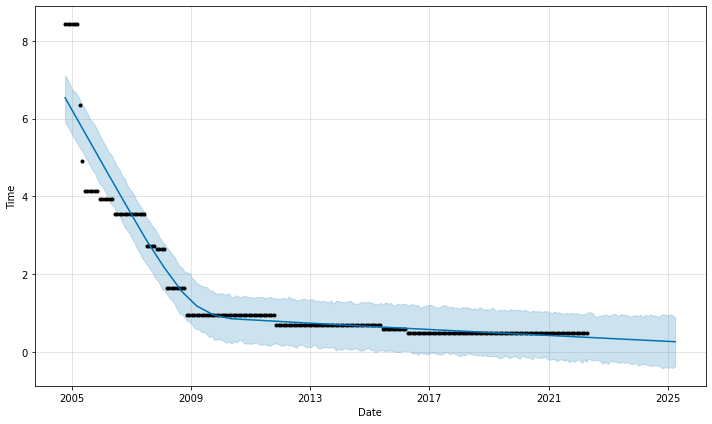

In [261]:
two.fb_graphics()

For saving time.

In [263]:
three.modeling_previsions(n_prev=36), 
four.modeling_previsions(n_prev=36), 
five.modeling_previsions(n_prev=36), 
six.modeling_previsions(n_prev=36), 
seven.modeling_previsions(n_prev=36)

Modelando com Facebook Prophet... -- Modelando with Facebook Prophet...
Modelando Facebook Prophet... -- Modeling Facebook Prophet...
Modelagem concluida! -- Sucessfull modeling!
Prevendo com Facebook Prophet... -- Predicting with Facebook Prophet...
Previsões concluidas! -- Sucessfully predicted!
Modelando com Facebook Prophet... -- Modelando with Facebook Prophet...
Modelando Facebook Prophet... -- Modeling Facebook Prophet...
Modelagem concluida! -- Sucessfull modeling!
Prevendo com Facebook Prophet... -- Predicting with Facebook Prophet...
Previsões concluidas! -- Sucessfully predicted!
Modelando com Facebook Prophet... -- Modelando with Facebook Prophet...
Modelando Facebook Prophet... -- Modeling Facebook Prophet...
Modelagem concluida! -- Sucessfull modeling!
Prevendo com Facebook Prophet... -- Predicting with Facebook Prophet...
Previsões concluidas! -- Sucessfully predicted!
Modelando com Facebook Prophet... -- Modelando with Facebook Prophet...
Modelando Facebook Prophet... -

The Rubik's cube time series.

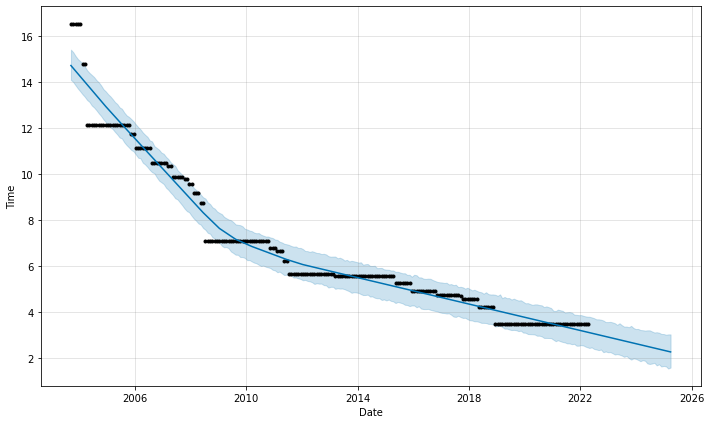

In [264]:
three.fb_graphics()

The Rubik's Revenge cube time series.

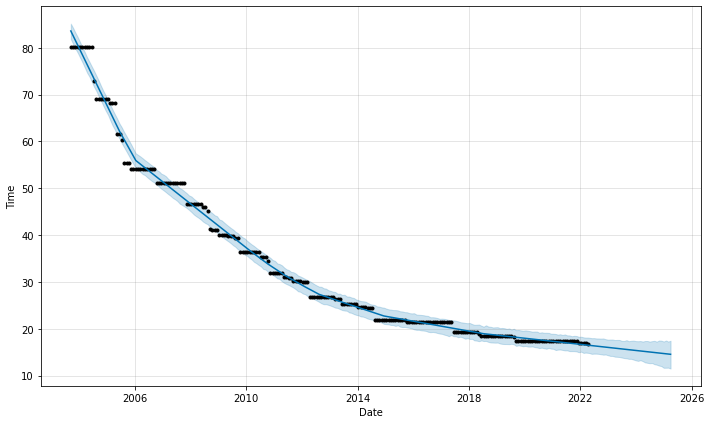

In [265]:
four.fb_graphics()

The Professor's cube time series.

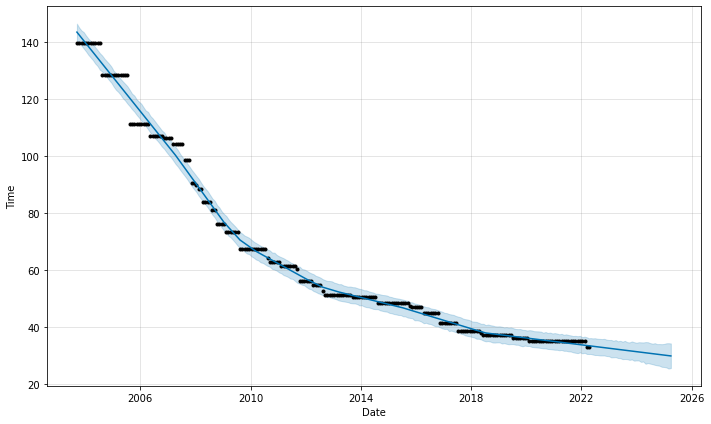

In [266]:
five.fb_graphics()

The V-6 cube time series.

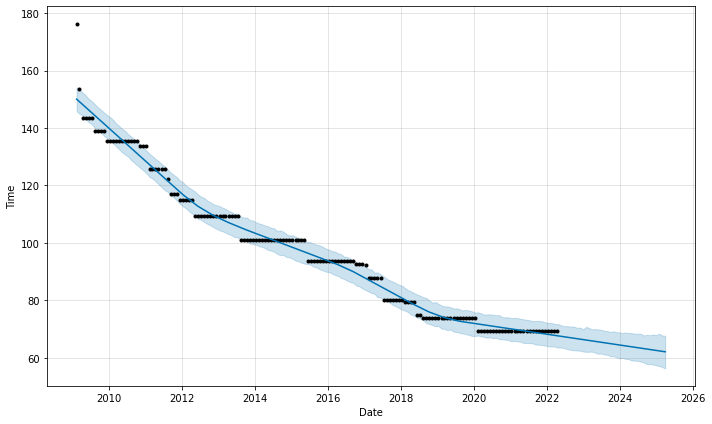

In [267]:
six.fb_graphics()

The V-7 cube time series.

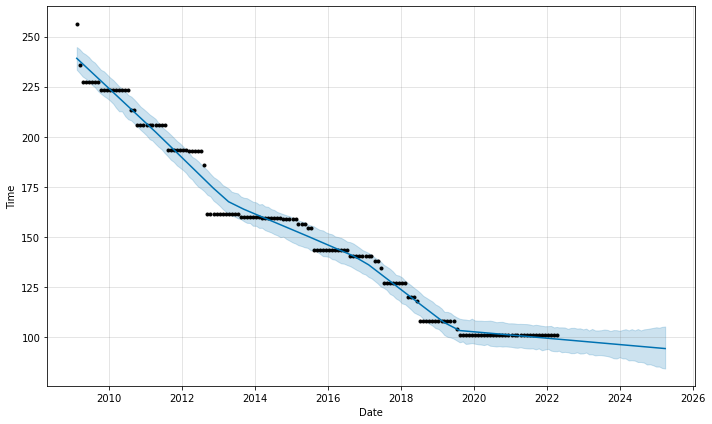

In [268]:
seven.fb_graphics()

They're not so bad predictions, yet they're steeper than the other models and this makes me think they're not so viable models rather than poisson models.

#### Conclusion

First adressing the pseudo overfit to the latest records. 

You may remember that in machine learning subject we look for models that are generic, fitting in between all the data; That's been said, comparing to the latest records wouldn't make the model overfit to these records? 

Well, yes; however this is not a big deal. See: all the records are always dependent of each other once they're always lesser than the previous. It is the decreasing trend of the records. So the older records already are higher than the newests, but the predictions need to be strictly lesser than the current records and it will not be fully achieved if not given the right amount of relevance to the latests records.

Another important point in looking to the newests records is the tendency of the derivative of the model to aproach zero. It says the records shall come to a stabilization because there is a limit to where the human being can be fast in solving the puzzle and maybe we're getting closer to the limit. The further in time, the lesser is the difference between latest records.

This can be seen in the Pocket cube graphic: There was no single record since 2016. Maybe it is the limit time for solving the cube. Then from 2016 and beyond the derivative of the Pocket cube's model would be zero, and there would not have a new record for the two by two cube.

And this pretty much resumes the model creation.

Thank you for your patience and reading!